Let start by importing necessary package 

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `c:\Users\uiv02757\OneDrive - Vitesco Technologies\git_repos\preconditioning`
   Resolving package versions...
  No Changes to `C:\Users\uiv02757\OneDrive - Vitesco Technologies\git_repos\preconditioning\Project.toml`
  No Changes to `C:\Users\uiv02757\OneDrive - Vitesco Technologies\git_repos\preconditioning\Manifest.toml`


In [2]:
using OptimalControl
using Plots
using ForwardDiff
using DifferentialEquations
using MINPACK

We consider the following optimal control problem 


$$
    \left\{ \begin{array}{ll}
    \displaystyle \min_{x,u} \int_{0}^{t_f} x(t) ~\mathrm dt \\[1em]
    \text{s.c.}~\dot x(t) = u(t), & t\in [0, t_f]~\mathrm{a.e.}, \\[0.5em]
    \phantom{\mathrm{s.c.}~} u(t) \in [-1,1], & t\in [0, t_f], \\[0.5em]
    \phantom{\mathrm{s.c.}~} x(t_0) = 0, \quad x(t_f) = x_f,
    \end{array} \right.
$$
with $t_0 = 0$, $x_0 = 0$, and $t_f = 5$.

In [3]:
t0 = 0
tf = 5
x0 = 0
@def ocp begin

    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control

    x(t0) == x0

    ẋ(t) == u(t)      

    ∫( x(t) ) → min

end;

In [4]:
ϕ = Flow(ocp, (x,p) -> sign(p))
Π((x,p)) = x

Π (generic function with 1 method)

# Simple shooting

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\uiv02757\.julia\packages\SciMLBase\rR75x\src\performance_warnings.jl:33


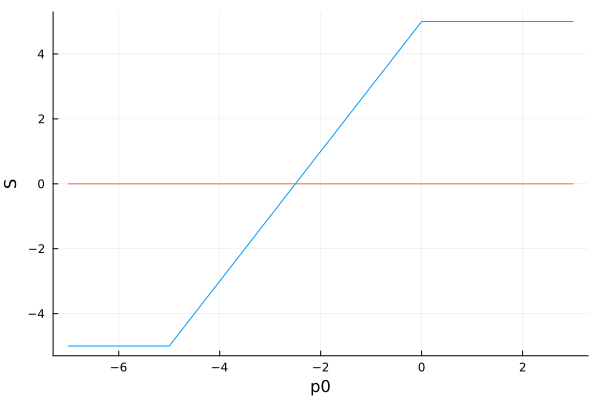

In [5]:
xf = 0.0
S(p0) = Π( ϕ(t0, x0, p0, tf) ) - xf;        # shooting function
nle = p0 -> [S(p0[1])]                      # intermediate function

# Plot
plot(range(-7, 3, 500), S)
plot!([-7,3], [0,0])
plot!(xlabel = "p0", ylabel = "S", legend=false)

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.000000e+00     0.000000e+00         0.133000
     2     1.849348e-01     2.535952e+00         0.183000
     3     5.323753e-09     8.550216e-03         0.000000
     4     1.275326e-08     7.085586e-18         0.000000
     5     4.867232e-09     3.526670e-18         0.000000
     6     1.950006e-08     6.985551e-17         0.000000
     7     1.263185e-08     4.473609e-17         0.000000
     8     9.386460e-10     6.585931e-19         0.016000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [-1.0]
 * Zero: [-2.49999999639132]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 0.332000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 2


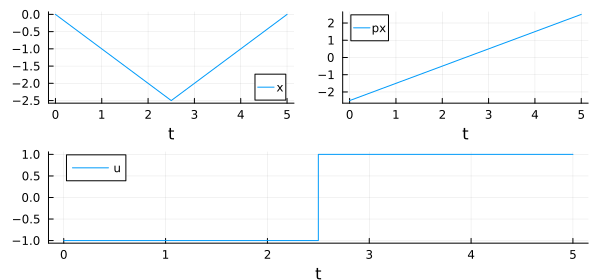

In [6]:
# Finite differences 
ξ = [-1.0]                                      # initial guess
S!(s, ξ) = (s[:] .= S(ξ[1]); nothing)           # intermediate function
p0_sol = fsolve(S!, ξ, show_trace = true)       # solve
println(p0_sol)
sol = ϕ((t0, tf), x0, p0_sol.x)                 # get the optimal trajectory
plot(sol)                                       # plot

Jacobian on ξ : 0.0
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.000000e+00     0.000000e+00         0.000000
     2     5.000000e+00     1.000000e+04         0.051000
     3     5.000000e+00     3.906250e+03         0.001000
     4     5.000000e+00     3.906250e+03         0.004000
     5     5.000000e+00     3.906250e+03         0.000000
     6     5.000000e+00     5.493164e+02         0.000000
     7     5.000000e+00     7.724762e+01         0.000000
     8     9.550781e-01     1.086295e+01         0.000000
     9     8.497947e-09     2.280436e-01         0.000000
    10     6.023568e-09     1.805378e-17         0.000000
    11     1.950005e-08     1.069900e-16         0.000000
    12     4.602006e-09     6.244968e-17         0.000000
    13     1.950005e-08     6.244953e-17         0.000000
    14     1.280357e-08     4.087826e-17         0.000000
    15     2.387695e-01     1.425272e-02         0.015000

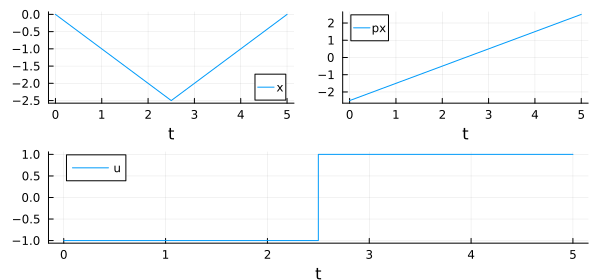

In [7]:
# autodiff : forward 
ξ = [-1.0]                                      # initial guess
jS(ξ) = ForwardDiff.jacobian(p -> [S(p[1])], ξ) # compute jacobian by forward differentiation
println("Jacobian on ξ : ", jS(ξ)[1])
jS!(js, ξ) = (js[:] .= jS(ξ); nothing)          # intermediate function

p0_sol = fsolve(S!, jS!, ξ, show_trace = true)  # solve
println(p0_sol)
sol = ϕ((t0, tf), x0, p0_sol.x)
plt = plot(sol)

Jacobian on ξ : 2.0
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.000000e+00     0.000000e+00         0.501000
     2     1.021405e-13     2.250000e+00         0.000000
     3     2.691181e-13     2.608171e-27         0.000000
     4     1.407763e-13     6.749691e-27         0.000000
     5     2.691181e-13     6.749691e-27         0.000000
     6     1.407763e-13     6.749691e-27         0.015000
     7     6.217249e-15     1.292470e-26         0.000000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell (User Jac, Expert)
 * Starting Point: [-1.0]
 * Zero: [-2.5000000000000826]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 0.516000 seconds
 * Function Calls: 7
 * Jacobian Calls (df/dx): 2


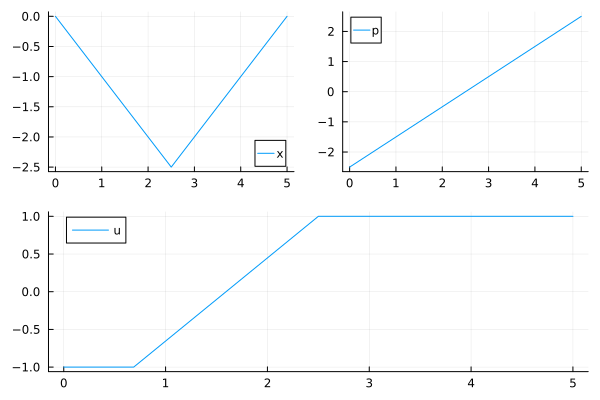

In [16]:
# detection de changement 
global α

function condition(z, t, integrator) # Event when condition(u,t,integrator) == 0
    x,p = z
    return p
end

function affect!(integrator)
    global α = -α
    nothing
end

cb = ContinuousCallback(condition, affect!)

φ_ = Flow(ocp, (x,p) -> α, callback = cb)

function φ(t0, x0, p0, tf)
    global α = sign(p0)
    return φ_(t0, x0, p0, tf)
end

function φ((t0, tf), x0, p0)
    global α = sign(p0)
    return φ_((t0, tf), x0, p0)
end

Shoot(p0) = Π( φ(t0, x0, p0, tf) ) - xf

ξ = [-1.0]                                                  # initial guess
jShoot(ξ) = ForwardDiff.jacobian(p -> [Shoot(p[1])], ξ)     # compute jacobian by forward differentiation
println("Jacobian on ξ : ", jShoot(ξ)[1])
Shoot!(shoot, ξ) = (shoot[:] .= Shoot(ξ[1]); nothing)       # intermediate function
jShoot!(jshoot, ξ) = (jshoot[:] .= jShoot(ξ); nothing)      # intermediate function

p0_sol = fsolve(Shoot!, jShoot!, ξ, show_trace = true)      # solve
println(p0_sol)
sol_ = φ((t0, tf), x0, p0_sol.x[1])

sol = OptimalControl.OptimalControlSolution(sol_)
t = sol.times
x = sol.state
p = sol.costate
u = sign ∘ p

plt_x = plot(t, x, label = "x")
plt_p = plot(t, p, label = "p")
plt_u = plot(t, u, label = "u")

plt_xp = plot(plt_x, plt_p, layout=(1, 2))
plot(plt_xp, plt_u, layout = (2, 1))

In [13]:
f = x -> x
g = sign ∘ f 
g(-0.1)

-1.0